This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch internet, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver plo). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [132]:
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
import matplotlib.pyplot as plt
%matplotlib inline

(50000, 1, 28, 28) (50000,)


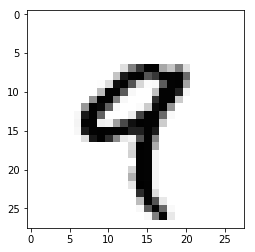

In [133]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()
plt.imshow(X_train[4].reshape(28, 28),cmap='Greys')
print(X_train.shape,y_train.shape)

In [134]:
def sample_noise(M):
    return np.float32(np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01).reshape(M,1)

In [135]:
G_input = T.matrix('Gx')

In [136]:
G_l1 = lasagne.layers.InputLayer((None, 1), G_input)
G_l2 = lasagne.layers.DenseLayer(G_l1, 64, nonlinearity=rectify)
G_l3 = lasagne.layers.DropoutLayer(G_l2, 0.5)
G_l4 = lasagne.layers.DenseLayer(G_l3, 256, nonlinearity=rectify)
G_l5 = lasagne.layers.DropoutLayer(G_l4, 0.5)
G_l6 = lasagne.layers.DenseLayer(G_l5, 784, nonlinearity=linear)
G_l7 = lasagne.layers.ReshapeLayer(G_l6,(-1,1,28,28))
G = G_l7
G_out = lasagne.layers.get_output(G)

In [137]:
D1_input = T.tensor4("D1X")

In [138]:
#D1_target = T.matrix('D1y')
D1_l1 = lasagne.layers.InputLayer((None, 1,28,28), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 256, nonlinearity=tanh)
D1_l3 = lasagne.layers.DropoutLayer(D1_l2, 0.5)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 64, nonlinearity=tanh)
D1_l5 = lasagne.layers.DropoutLayer(D1_l4, 0.5)
D1_l6 = lasagne.layers.DenseLayer(D1_l5, 1, nonlinearity=sigmoid)
D1 = D1_l6

In [139]:
D2_l1 = lasagne.layers.InputLayer((None, 1,28,28), G_out)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 256, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DropoutLayer(D2_l2, 0.5)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 64, nonlinearity=tanh, W=D1_l4.W, b=D1_l4.b)
D2_l5 = lasagne.layers.DropoutLayer(D2_l4, 0.5)
D2_l6 = lasagne.layers.DenseLayer(D2_l5, 1, nonlinearity=sigmoid, W=D1_l6.W, b=D1_l6.b)
D2 = D2_l6

In [140]:
D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

In [141]:
G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

In [142]:
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates)

In [143]:
D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)


In [144]:
G_output = theano.function([G_input], G_out)

In [149]:
def iterate_minibatches(inputs, batchsize):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
    return inputs[excerpt]

In [150]:
import matplotlib.pyplot as plt
epochs = 5000
k = 500
M = 200  # mini-batch size
mu = 3
sigma = 0.5
for i in range(epochs):
    x = iterate_minibatches(X_train,k)
    z = sample_noise(k)
    D_train(z, x)
    z = sample_noise(M)
    G_train(z)
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
        

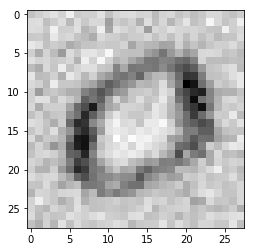

In [171]:
z = sample_noise(1)
plt.imshow(G_output(z).reshape(28, 28),cmap='Greys')